In [35]:
#import packages 
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

In [36]:
#import tweet data
data = pd.read_csv("tweets_tagged.csv",delimiter=',', encoding='latin-1')
print(data.head())
print(data.describe())

   Sr No                                              tweet  label
0      1  Hysteria surrounding #coronavirus NZ daycare r...      3
1      2  Thank you @TheOnion for dragging all of us und...      1
2      3  #avetmissdone is catching on faster than the #...      1
3      4  They just said #Tonysnell was back from the fl...      2
4      5  Forget locking them up on an island to die slo...      2
             Sr No         label
count  10000.00000  10000.000000
mean    5000.50000      1.879200
std     2886.89568      0.784518
min        1.00000      1.000000
25%     2500.75000      1.000000
50%     5000.50000      2.000000
75%     7500.25000      3.000000
max    10000.00000      3.000000


In [37]:
#remove urls 
def remove_URL(sample):
    """Remove URLs from a string"""
    return re.sub(r"http\S+", "", sample)
print(data['tweet'][1])
data['tweet']=[remove_URL(tweet) for tweet in data['tweet']]
print(data['tweet'][1])

Thank you @TheOnion for dragging all of us under the artful guise of satire. V helpful #coronavirus advice ?? https://t.co/Oly95Sul5f
Thank you @TheOnion for dragging all of us under the artful guise of satire. V helpful #coronavirus advice ?? 


In [38]:
#seperate dataframe to positive, negative, and both tweets
pos_tweets =data['tweet'][data['label']==1]
neg_tweets = data['tweet'][data['label']==3]
pos_neg_tweets = data['tweet'][data['label']!=2]

#examine the data
print(pos_neg_tweets.head())
print(len(pos_tweets)/len(pos_neg_tweets))

0    Hysteria surrounding #coronavirus NZ daycare r...
1    Thank you @TheOnion for dragging all of us und...
2    #avetmissdone is catching on faster than the #...
5    Please keep posted!?????? #CoronaVirus #Gensan...
6     What did Richard Jefferson say? ?? #coronavirus 
Name: tweet, dtype: object
0.5958730158730159


In [39]:
#to lower case  
pos_neg_tweets = [tweet.lower() for tweet in pos_neg_tweets]
pos_tweets = [tweet.lower() for tweet in pos_tweets]
neg_tweets = [tweet.lower() for tweet in neg_tweets]

In [40]:
print(pos_tweets[:5])
print(neg_tweets[:5])

['thank you @theonion for dragging all of us under the artful guise of satire. v helpful #coronavirus advice ?? ', '#avetmissdone is catching on faster than the #coronavirus... but no deaths yet! ??', '#wuhancoronavirus #coronavirus\na young man was recovered and discharged from a local hospital in shanxi. best wishes! ???\n', '#wuhancoronavirus #coronavirus\na young man was recovered and discharged from the local hospital in shanxi. best wishes! ????????? ', 'japan flies citizens home from virus-hit wuhan  via @youtube #coronavirus ??']
['hysteria surrounding #coronavirus nz daycare requesting all children who have visited a country with any confirmed cases be excluded for 2 weeks. this includes australia. so, despite us only visiting adelaide where there are no confirmed cases, we are in this category ??', 'please keep posted!?????? #coronavirus #gensan #stelizabethhospitalinc #sehi ', 'what did richard jefferson say? ?? #coronavirus ', 'halt???\nall??commercial??flights??from #china

In [41]:
#convert emoticons to words before tokenizing

# Function for converting emoticons into word

def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
        text=text.replace("_".join(EMOTICONS[emot].replace(",","").split()), " "+"_".join(EMOTICONS[emot].replace(",","").split()))
    return text


#example
text2 = "Hilarious:-). The feeling of making a sale :-(, The feeling of actually fulfilling orders ;-)"
print(convert_emoticons(text2))


Hilarious           Happy_face_smiley. The feeling of making a sale              Frown_sad_andry_or_pouting, The feeling of actually fulfilling orders ;- Confusion


In [42]:
#use Tweet tokenizer (preserves hashtag and @)
tknzr = TweetTokenizer()

pos_tokens = [tknzr.tokenize(tweet) for tweet in pos_tweets]
neg_tokens = [tknzr.tokenize(tweet) for tweet in neg_tweets]
tweet_tokens = [tknzr.tokenize(tweet) for tweet in pos_neg_tweets]
print(pos_tokens[1])
print(neg_tokens[1])
print(tweet_tokens[1])

['#avetmissdone', 'is', 'catching', 'on', 'faster', 'than', 'the', '#coronavirus', '...', 'but', 'no', 'deaths', 'yet', '!', '?', '?']
['please', 'keep', 'posted', '!', '?', '?', '?', '#coronavirus', '#gensan', '#stelizabethhospitalinc', '#sehi']
['thank', 'you', '@theonion', 'for', 'dragging', 'all', 'of', 'us', 'under', 'the', 'artful', 'guise', 'of', 'satire', '.', 'v', 'helpful', '#coronavirus', 'advice', '?', '?']


In [43]:
#normalization 
#tagging position of word in sentence
#show example for first tweet
print(pos_tag(pos_tokens[0]))

[('thank', 'NN'), ('you', 'PRP'), ('@theonion', 'VBP'), ('for', 'IN'), ('dragging', 'VBG'), ('all', 'DT'), ('of', 'IN'), ('us', 'PRP'), ('under', 'IN'), ('the', 'DT'), ('artful', 'JJ'), ('guise', 'NN'), ('of', 'IN'), ('satire', 'NN'), ('.', '.'), ('v', 'NN'), ('helpful', 'JJ'), ('#coronavirus', 'NN'), ('advice', 'NN'), ('?', '.'), ('?', '.')]


In [44]:
#remove noise and lemmatize (copy and pasted from blog)

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
    
        #token = re.sub("(@[A-Za-z0-9_]+)","", token) #this would delete @handles?
        token=re.sub("([^A-Za-z#])","", token) #this deletes all numbers and punctuations, though it also transforms #ncov19 to #ncov
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        #use if condition to drop single character strings
        if len(token) > 1 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

#example
print(remove_noise(neg_tokens[1]))

['please', 'keep', 'post', '#coronavirus', '#gensan', '#stelizabethhospitalinc', '#sehi']


In [45]:
#define stopwords to remove
stop_words = stopwords.words('english')

In [46]:
#apply remove_noise function
pos_tokens_cleaned = []
neg_tokens_cleaned = []
tweet_tokens_cleaned = []

for tokens in pos_tokens:
    pos_tokens_cleaned.append(remove_noise(tokens, stop_words))

for tokens in neg_tokens:
    neg_tokens_cleaned.append(remove_noise(tokens, stop_words))

for tokens in tweet_tokens:
    tweet_tokens_cleaned.append(remove_noise(tokens, stop_words))

In [47]:
print(pos_tokens_cleaned[0])
print(neg_tokens_cleaned[0])
print(tweet_tokens_cleaned[0])

['thank', 'theonion', 'drag', 'us', 'artful', 'guise', 'satire', 'helpful', '#coronavirus', 'advice']
['hysteria', 'surround', '#coronavirus', 'nz', 'daycare', 'request', 'child', 'visit', 'country', 'confirmed', 'case', 'exclude', 'week', 'include', 'australia', 'despite', 'us', 'visit', 'adelaide', 'confirmed', 'case', 'category']
['hysteria', 'surround', '#coronavirus', 'nz', 'daycare', 'request', 'child', 'visit', 'country', 'confirmed', 'case', 'exclude', 'week', 'include', 'australia', 'despite', 'us', 'visit', 'adelaide', 'confirmed', 'case', 'category']


In [48]:
#Frequencies with get_all_words
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_tokens = get_all_words(tweet_tokens_cleaned)


In [49]:
#word frequencies for all words - this does not allow to plot a histogram
freq_dist = FreqDist(all_tokens)
print(freq_dist.most_common(50))

[('#coronavirus', 6311), ('china', 737), ('case', 598), ('#coronavirusoutbreak', 575), ('virus', 520), ('#ncov', 510), ('#china', 490), ('spread', 473), ('people', 466), ('get', 365), ('coronavirus', 332), ('#wuhan', 318), ('new', 306), ('death', 305), ('safe', 297), ('go', 270), ('mask', 268), ('late', 262), ('update', 260), ('like', 259), ('us', 256), ('time', 254), ('know', 241), ('outbreak', 241), ('health', 234), ('confirm', 229), ('day', 229), ('say', 227), ('wuhan', 226), ('please', 221), ('corona', 220), ('stay', 217), ('good', 216), ('country', 208), ('news', 208), ('one', 206), ('world', 203), ('infect', 202), ('need', 197), ('make', 196), ('take', 188), ('dont', 183), ('everyone', 181), ('chinese', 180), ('report', 170), ('hospital', 165), ('first', 164), ('see', 164), ('im', 161), ('patient', 160)]


In [50]:
#count words with counter function to later drop most frequent words and plot a histogram

word_counter={}
for tweet in tweet_tokens_cleaned:
    for word in tweet:
        if word != '':
            if word in word_counter:
                word_counter[word] +=1
            else:
                word_counter[word] = 1

popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
top_200 = popular_words[:200]
top_50=popular_words[:50]
top_10 = popular_words[:10]
#print top 50 words
print(top_50)  
 

['#coronavirus', 'china', 'case', '#coronavirusoutbreak', 'virus', '#ncov', '#china', 'spread', 'people', 'get', 'coronavirus', '#wuhan', 'new', 'death', 'safe', 'go', 'mask', 'late', 'update', 'like', 'us', 'time', 'know', 'outbreak', 'health', 'confirm', 'day', 'say', 'wuhan', 'please', 'corona', 'stay', 'good', 'country', 'news', 'one', 'world', 'infect', 'need', 'make', 'take', 'dont', 'everyone', 'chinese', 'report', 'hospital', 'first', 'see', 'im', 'patient']


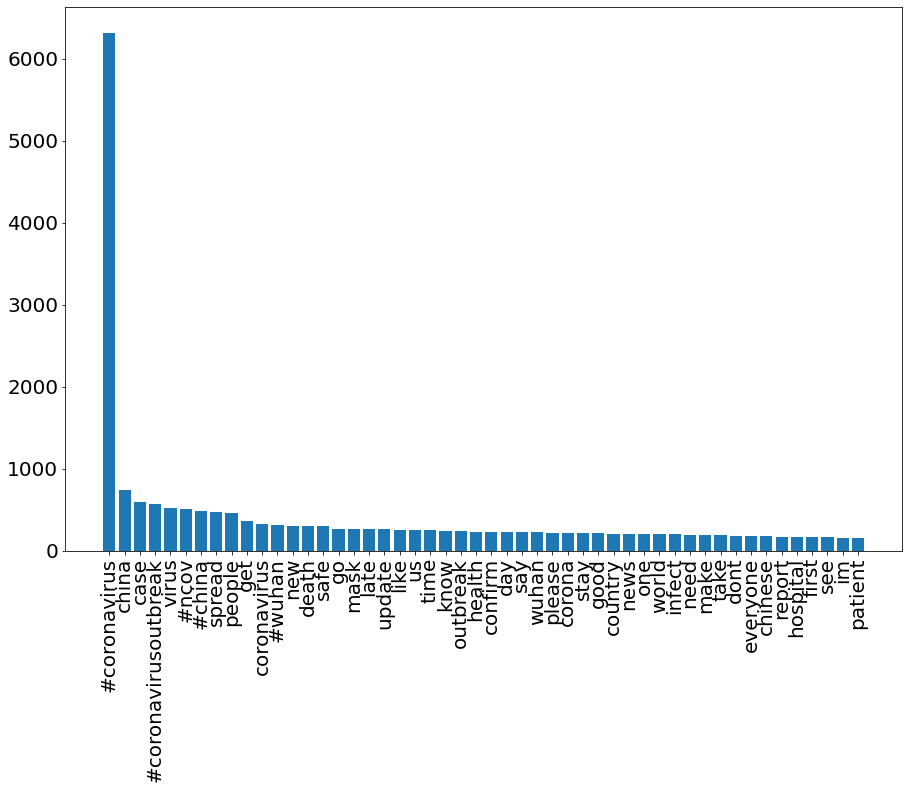

In [51]:
#plot most distribution of 50 most common words
#get values of word_counter for most common 50 words
freq = []
words = []
sorted_freq=dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True))
for key, value in sorted_freq.items():
    if key in top_50:
        freq.append(value)
        words.append(key)
#make bar plot of most frequent words
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(height=freq, x=words, width=0.8)
plt.xticks(rotation=90)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.show()


In [52]:
#make list of pos and negative words from list of tweets to be able to delete most frequent words and count words looping over list
pos_words = []
neg_words = []

for tweet in pos_tokens_cleaned:
    for word in tweet:
        pos_words.append(word)
        
for tweet in neg_tokens_cleaned:
    for word in tweet:
        neg_words.append(word)
 


In [53]:
#count and plot top words in positive and negative tweets that are not in top50
count_pos={}
for word in pos_words:
    if word not in top_10:
        if word in count_pos:
            count_pos[word] +=1
        else:
            count_pos[word] = 1

popular_pos_words = sorted(count_pos, key = count_pos.get, reverse = True)
top_20_pos_words=popular_pos_words[:20]
count_neg={}
for word in neg_words:
    if word not in top_10:
        if word in count_neg:
            count_neg[word] +=1
        else:
            count_neg[word] = 1



In [54]:
#get frequencies from dictionaries in a sorted way as tuples for plotting top20
#positive
freq_pos = []
words_pos = []
sorted_freq_pos= [(k, v) for k, v in count_pos.items()]
sorted_freq_pos=sorted(sorted_freq_pos, key=lambda tup: tup[1], reverse=True)
words_pos = [a for (a,_) in sorted_freq_pos]
freq_pos = [b for (_,b) in sorted_freq_pos]




In [55]:
#negative
freq_neg = []
words_neg = []
sorted_freq_neg= [(k, v) for k, v in count_neg.items()]
sorted_freq_neg=sorted(sorted_freq_neg, key=lambda tup: tup[1], reverse=True)
words_neg = [a for (a,_) in sorted_freq_neg]
freq_neg = [b for (_,b) in sorted_freq_neg]



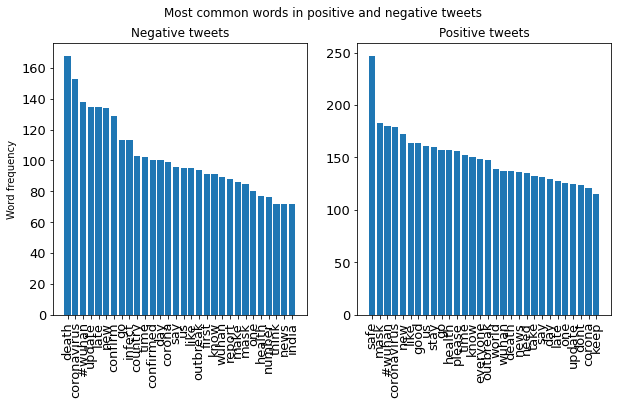

In [56]:
#make bar plot of frequencies 
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(1,2,1)

#This will create first plot
neg = plt.bar(words_neg[:30], freq_neg[:30])
plt.title('Negative tweets')
plt.ylabel('Word frequency')
plt.xticks(rotation='vertical')
plt.tick_params(axis='both', which='major', labelsize=13)
#The below code will create the second plot.
plt.subplot(1,2,2)
#This will create the second plot
pos =plt.bar(words_pos[:30], freq_pos[:30])
plt.title('Positive tweets')
plt.xticks( rotation='vertical')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.suptitle('Most common words in positive and negative tweets')
plt.show() 

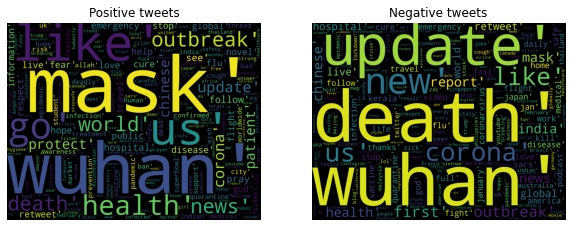

In [57]:
#in addition make word cloud as alternative illustration

from wordcloud import WordCloud
fig, ax = plt.subplots(figsize=(10, 5))

#positive
plt.subplot(1,2,1)
wordcloud_pos = WordCloud(width=1800,height=1400).generate(str(words_pos))
plt.imshow(wordcloud_pos)
plt.title('Positive tweets')
plt.axis("off")

#negative
plt.subplot(1,2,2)
wordcloud_neg = WordCloud(width=1800,height=1400).generate(str(words_neg))
plt.imshow(wordcloud_neg)
plt.title('Negative tweets')
plt.axis("off")

plt.show()

In [58]:
#preparing data for modelling
#make dict out of lists of tokens with keys = tokens and values=true

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(pos_tokens_cleaned)
negative_tokens_for_model = get_tweets_for_model(neg_tokens_cleaned)

In [59]:
#test and training set split for Naive Bayes model
#joining positive and negative tweets with additional tag, and shuffle into 1 set
import random

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset
random.shuffle(dataset)

#we have 6,300 tweets after dropping the neutral ones
train_size=int(len(dataset)*0.7) # set training dataset size to 0.7 of all data
print(train_size)
train_data = dataset[:train_size]
test_data = dataset[train_size:]
print(dataset[:5])

4410
[({'love': True, 'lilhuddy': True, '#bafta': True, '#abrelosojos': True, '#superbowl': True, '#metoo': True, '#coronavirus': True, '#shakirasuperbowl': True, '#armyselcaday': True}, 'Negative'), ({'#coronavirus': True, 'get': True, 'bad': True, 'day': True, 'might': True, 'worth': True, '#prepping': True, 'apparently': True, 'mask': True, 'sell': True, '#belfast': True, '#n': True, 'online': True, 'cant': True, '#march': True}, 'Negative'), ({'real': True, 'remember': True, '#coronavirus': True}, 'Negative'), ({'#philippines': True, 'first': True, 'report': True, 'death': True, 'due': True, '#coronavirus': True, 'outside': True, '#china': True, 'let': True, 'us': True, 'hope': True, 'expert': True, 'practitioner': True, 'field': True, 'find': True, 'solution': True, 'begin': True, 'many': True, 'fellow': True, 'human': True, 'die': True, 'rip': True}, 'Positive'), ({'life': True, 'go': True, 'people': True, 'kill': True, 'time': True, 'stick': True, 'home': True, 'amid': True, '#c

In [60]:
#Using NLTK Package to build Naive Bayes Model - it has slightly different accuracy from sklean Naive Bayes module below ...how?
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))


Accuracy is: 0.5925925925925926
Most Informative Features
                 respect = True           Positi : Negati =     20.2 : 1.0
                 podcast = True           Negati : Positi =     10.9 : 1.0
                  energy = True           Negati : Positi =     10.3 : 1.0
                    ctto = True           Negati : Positi =      8.3 : 1.0
                database = True           Negati : Positi =      7.8 : 1.0
    #coronavirusenfrance = True           Negati : Positi =      7.4 : 1.0
                   #live = True           Negati : Positi =      7.4 : 1.0
                   #mers = True           Negati : Positi =      7.4 : 1.0
                   pheuk = True           Negati : Positi =      7.4 : 1.0
                   islam = True           Positi : Negati =      7.0 : 1.0
None


In [61]:
#Transform dataset to use other models
#requires count vectorization - basically the same as above but would take into account when tokens occur multiple times in tweet?!
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Create our vectorizer
vectorizer = CountVectorizer()



In [62]:
#to use count vectorization, format of x (tweets) needs to be a simple list of strings

neg_list = []
pos_list = []

for tweet in neg_tokens_cleaned:
    tw=''
    for word in tweet:
        tw=tw+word+' '
    tw=tw[:-1] #get rid of space at the end of tweet
    neg_list.append(tw)

for tweet in pos_tokens_cleaned:
    tw=''
    for word in tweet:
        tw=tw+word+' '
    tw=tw[:-1] #get rid of space at the end of tweet
    pos_list.append(tw)
    
#add positive and negative category and shuffle

pos_set = [(tweet, 1)
                     for tweet in pos_list]

neg_set = [(tweet, 0)
                     for tweet in neg_list]

ds = pos_set + neg_set
random.shuffle(ds)

#we have 6,300 tweets after dropping the neutral ones
train_size=int(len(ds)*0.7) # set training dataset size to 0.7 of all data
print(train_size)
train_data = ds[:train_size]
test_data = ds[train_size:]


#generate x_train, y_train, x_test, y_test
x_test = [a for (a,_) in test_data]
x_train = [a for (a,_) in train_data]
y_test = [b for (_,b) in test_data]
y_train = [b for (_,b) in  train_data]

# Get the training vectors
vectors = vectorizer.fit_transform(x_train)

# Get the test vectors
vectors_test = vectorizer.transform(x_test)

4410


In [63]:
#Naive Bayes
# Build the classifier
nb= MultinomialNB(alpha=.01)

#  Train the classifier
nb.fit(vectors, y_train)

# Predict and score the vectors
nb_pred = nb.predict(vectors_test)
nb_acc_score = metrics.accuracy_score(y_test, nb_pred)
nb_f1_score = metrics.f1_score(y_test, nb_pred, average='macro')

print('Naive Bayes: Total accuracy classification score: {}'.format(nb_acc_score))
print('Naive Bayes: Total F1 classification score: {}'.format(nb_f1_score))


Naive Bayes: Total accuracy classification score: 0.5962962962962963
Naive Bayes: Total F1 classification score: 0.5693219180311859


In [91]:
#Logistic regression

# Build the classifier with different values of regularization strength

def logreg(cval=1,cweight=None):
    lr= LogisticRegression(C=cval, class_weight=cweight)
    lr.fit(vectors, y_train) #train
    lr_pred = lr.predict(vectors_test) #predict
    lr_acc_score = metrics.accuracy_score(y_test, lr_pred)
    lr_f1_score = metrics.f1_score(y_test, lr_pred, average='macro')
    return lr_acc_score, lr_f1_score, lr_pred


    # Predict and score the vectors for different values of C
c=[0.001, 0.01, 0.1, 1,10,100]
class_weight=[None, 'balanced']*3

for  cweight, cval in zip( class_weight, c):
    logreg(cval, cweight)
    print('Logistic Regression for C=%f and class_weight=%s: Total accuracy classification score: %f, Total F1 classification score: %f' %  (cval, cweight, lr_acc_score, lr_f1_score))

Logistic Regression for C=0.001000 and class_weight=None: Total accuracy classification score: 0.604233, Total F1 classification score: 0.567617
Logistic Regression for C=0.010000 and class_weight=balanced: Total accuracy classification score: 0.604233, Total F1 classification score: 0.567617
Logistic Regression for C=0.100000 and class_weight=None: Total accuracy classification score: 0.604233, Total F1 classification score: 0.567617
Logistic Regression for C=1.000000 and class_weight=balanced: Total accuracy classification score: 0.604233, Total F1 classification score: 0.567617


C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression for C=10.000000 and class_weight=None: Total accuracy classification score: 0.604233, Total F1 classification score: 0.567617
Logistic Regression for C=100.000000 and class_weight=balanced: Total accuracy classification score: 0.604233, Total F1 classification score: 0.567617


C:\Users\freudenreich\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
#Decision tree classifier

# Build the classifier
    #default
dt= DecisionTreeClassifier()
    #specify parameters: criterion=entropy
dt2= DecisionTreeClassifier(criterion='entropy')
    #class weight= balanced
dt3= DecisionTreeClassifier(class_weight='balanced')
    #random splitter
dt4= DecisionTreeClassifier(splitter="random")


#  Train the classifier
dt.fit(vectors, y_train)
dt2.fit(vectors,y_train)
dt3.fit(vectors,y_train)
dt4.fit(vectors,y_train)

# Predict and score the vectors
dt_pred = dt.predict(vectors_test)
dt_acc_score = metrics.accuracy_score(y_test, dt_pred)
dt_f1_score = metrics.f1_score(y_test, dt_pred, average='macro')
dt2_pred = dt2.predict(vectors_test)
dt2_acc_score = metrics.accuracy_score(y_test, dt2_pred)
dt2_f1_score = metrics.f1_score(y_test, dt2_pred, average='macro')
dt3_pred = dt3.predict(vectors_test)
dt3_acc_score = metrics.accuracy_score(y_test, dt3_pred)
dt3_f1_score = metrics.f1_score(y_test, dt3_pred, average='macro')
dt4_pred = dt4.predict(vectors_test)
dt4_acc_score = metrics.accuracy_score(y_test, dt4_pred)
dt4_f1_score = metrics.f1_score(y_test, dt4_pred, average='macro')

print('Decision Tree Classifier: Total accuracy classification score: {}'.format(dt_acc_score))
print('Decision Tree Classifier: Total F1 classification score: {}'.format(dt_f1_score))
print('Decision Tree Classifier with criterion=entropy: Total accuracy classification score: {}'.format(dt2_acc_score))
print('Decision Tree Classifier with criterion = entropy: Total F1 classification score: {}'.format(dt2_f1_score))
print('Decision Tree Classifier with class_weight=balanced: Total accuracy classification score: {}'.format(dt3_acc_score))
print('Decision Tree Classifier with class_weight=balanced: Total F1 classification score: {}'.format(dt3_f1_score))
print('Decision Tree Classifier with random splitter: Total accuracy classification score: {}'.format(dt4_acc_score))
print('Decision Tree Classifier with random splitter: Total F1 classification score: {}'.format(dt4_f1_score))

Decision Tree Classifier: Total accuracy classification score: 0.5666666666666667
Decision Tree Classifier: Total F1 classification score: 0.5472913551310986
Decision Tree Classifier with criterion=entropy: Total accuracy classification score: 0.553968253968254
Decision Tree Classifier with criterion = entropy: Total F1 classification score: 0.5318289164337227
Decision Tree Classifier with class_weight=balanced: Total accuracy classification score: 0.5497354497354497
Decision Tree Classifier with class_weight=balanced: Total F1 classification score: 0.5368707482993197
Decision Tree Classifier with random splitter: Total accuracy classification score: 0.5656084656084656
Decision Tree Classifier with random splitter: Total F1 classification score: 0.5491604777645513


In [32]:
#Random forest classifier

# Build the classifier
rf= RandomForestClassifier()

#  Train the classifier
rf.fit(vectors, y_train)

# Predict and score the vectors
rf_pred = rf.predict(vectors_test)
rf_acc_score = metrics.accuracy_score(y_test, rf_pred)
dt_f1_score = metrics.f1_score(y_test, rf_pred, average='macro')

print('Random Forest Classifier: Total accuracy classification score: {}'.format(dt_acc_score))
print('Random Forest Classifier: Total F1 classification score: {}'.format(dt_f1_score))

Random Forest Classifier: Total accuracy classification score: 0.5724867724867725
Random Forest Classifier: Total F1 classification score: 0.5736956336556331


In [33]:
#ROC curve

#import packages
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities for each of the classifiers
nb_probs = nb.predict_proba(vectors_test) #naive bayes
lr_probs = lr.predict_proba(vectors_test) #logistic regression
dt_probs = dt.predict_proba(vectors_test) #decision tree classifier
rf_probs = rf.predict_proba(vectors_test) #random forest classifier

# keep probabilities for the positive outcome only
nb_probs=nb_probs[:, 1]
lr_probs=lr_probs[:, 1]
dt_probs=dt_probs[:, 1]
rf_probs=rf_probs[:, 1]



No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.592
Logistic: ROC AUC=0.607
Decision Tree: ROC AUC=0.556
Random forest: ROC AUC=0.624


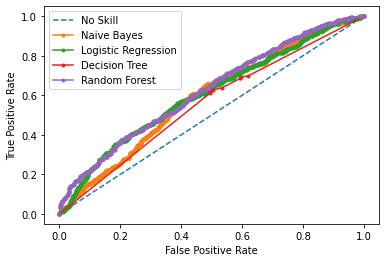

In [34]:
# calculate roc auc scores
ns_auc = roc_auc_score(y_test, ns_probs) #no skill
nb_auc = roc_auc_score(y_test, nb_probs) #naive bayes
lr_auc = roc_auc_score(y_test, lr_probs) #logistic regression
dt_auc = roc_auc_score(y_test, dt_probs) #decision tree
rf_auc = roc_auc_score(y_test, rf_probs) #random forests


# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('Decision Tree: ROC AUC=%.3f' % (dt_auc))
print('Random forest: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()